# Solución punto 1. Detección de mentiras mediante RoBERTa

## Nicolás Echeverri Rojas

Se escoge entrenar el modelo en las GPUs de Google Colab gracias a su bajo costo en comparación a otras alternativas como AWS Sagemaker

### Resumen de aproximación.

* Se eliminan los mensajes con menos de 5 palabras pues estos no aportan a la etección de mentiras debido a su poco consentido semántico. además que por su falta de contexto no para un humano sería imposible inferior si son verdad o mentira

* Se realiza submuestreo a razón negativos/positivos = 0.3 con el fin de impedir que el modelo aprende a minimizar solo la clase mayoritaría (positiva)

* Finetune de modelo RoBERTa Irony pues al ser preentrenado en un dataset para predicción de ironia/no ironia está más cerca de clasificar verdad/mentira que el modelo preentrenado para clasificar sentimientos.

### Resultados:

Macro F1-score sender: 0.57
Macro F1-score receiver: 0.53

### Conclusiones

Se observa que si bien el dataset tiene anotados según los mensajes sin son mentira o verdad se debe de realizar una mejor limpieza para construir un algoritmo robusto puesto que existen mensajes muy cortos, preguntas incluso emoticones con valores de verdad/mentira.

Se lograron resultados comparables al artículo

### Consideraciones

No se usó la variable power pues se desea tener un algoritmo que pueda ser generalizable a otras situaciones de tal manera que solo se enfocó en el texto.

## Alternativas siguientes.

Explorar un modelo híbrido en el cual se tenga a RoBERTa irony + Xgboost classifier y se promedien los resultados





### Otras aproximaciones exploradas:
* Incluir mayor contexto concatenando diferentes mensajes por partida.
* Finetune de RoBERTa + modificación de función de pérdida para priorizar clase minoritaria (negativos)

## Link de los modelos:
https://drive.google.com/drive/folders/1QyMWw2XhBC1ClhEmJvE8tmcdFibQEWRg?usp=sharing



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install jsonlines

In [ ]:
import jsonlines
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## 1. Carga de datos

In [ ]:
data_path = '/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica/2020_acl_diplomacy/data/'
with jsonlines.open(data_path+'train.jsonl', 'r') as reader:
    train = list(reader)
with jsonlines.open(data_path+'validation.jsonl', 'r') as reader:
    valid = list(reader)
with jsonlines.open(data_path+'test.jsonl', 'r') as reader:
    test = list(reader)

In [ ]:
#change the format from list of lists into a single list
def aggregate(dataset):
    '''Función que convierte los datos a formato para entrenamiento
      Esta función es tomada del código del paper original
    Se agrega la columna game_ids
    '''
    messages  = []
    rec       = []
    send      = []
    power     = []
    game_ids  = []

    for dialogs in dataset:
        messages.extend(dialogs['messages'])
        rec.extend(dialogs['receiver_labels'])
        send.extend(dialogs['sender_labels'])
        game_id = dialogs['game_id']
        game_ids.extend( [game_id for _ in range(len(dialogs['messages']) )] )

        #ONLY FOR POWER VERSION
        power.extend(dialogs['game_score_delta'])
    #print(len(rec), len(send), len(messages))
    merged = []
    for i, item in enumerate(messages):
        merged.append({'message':item, 'sender_annotation':send[i],
                        'receiver_annotation':rec[i], 'score_delta':int(power[i]),
                        'game_id': game_ids[i]
                        })
    return merged

In [ ]:
#only used for getting lie/not lie labels
data_train = aggregate(train)
data_val   = aggregate(valid)
data_test  = aggregate(test)

In [ ]:
len(data_train),len(data_val), len(data_test)

(13132, 1416, 2741)

Observando algunos datos

In [ ]:
data_train[110]

{'message': "Okay, Italy. I won't share any of this conversation. But in the interest of continued full disclosure, here's what I think: England is a greater threat to *me* on the map, but *you* have a greater chance of soloing this game quickly, or pair-winning with Austria even sooner. And if I continue to collaborate with England, we at least have a chance of slowing that down. So I'm in sort of a conflicted spot",
 'sender_annotation': True,
 'receiver_annotation': True,
 'score_delta': -3,
 'game_id': 1}

In [ ]:
df_train = pd.DataFrame(data_train)
df_train['set'] = 'train'

df_val   = pd.DataFrame(data_val)
df_val['set'] = 'val'

df_test  = pd.DataFrame(data_test)
df_test['set'] ='test'


In [ ]:
df_total = pd.concat([df_train,df_val,df_test])

## 2. Análisis de datos

### 2.1 proporción de variable objetivo

In [ ]:
df_train['receiver_annotation'].value_counts()

True            11459
NOANNOTATION     1107
False             566
Name: receiver_annotation, dtype: int64

In [ ]:
df_val['sender_annotation'].value_counts()

True     1360
False      56
Name: sender_annotation, dtype: int64

In [ ]:
df_val['receiver_annotation'].value_counts()

True            1236
NOANNOTATION     133
False             47
Name: receiver_annotation, dtype: int64

In [ ]:
df_test['sender_annotation'].value_counts()

True     2501
False     240
Name: sender_annotation, dtype: int64

In [ ]:
df_test['receiver_annotation'].value_counts()

True            2310
NOANNOTATION     266
False            165
Name: receiver_annotation, dtype: int64

In [ ]:
df_total['sender_annotation'].value_counts()

True     16402
False      887
Name: sender_annotation, dtype: int64

In [ ]:
df_total['receiver_annotation'].value_counts()

True            15005
NOANNOTATION     1506
False             778
Name: receiver_annotation, dtype: int64

Se observa que la variable objetivo está desbalanceada lo que afectará al modelo si no se aborda pues empezará a predecir la clase mayoritaría

In [ ]:
df_total.shape

(17289, 6)

### 2.2 Cantidad de palabras

In [ ]:
df_total.head(2)

,message,sender_annotation,receiver_annotation,score_delta,game_id,set
0,Germany!\n\nJust the person I want to speak wi...,True,True,0,1,train
1,"You've whet my appetite, Italy. What's the sug...",True,True,0,1,train


In [ ]:
df_total['cantidad_palabras'] = df_total['message'].str.split(" ").apply(len)

In [ ]:
df_total['cantidad_palabras'].describe()

count    17289.000000
mean        20.417433
std         21.599308
min          1.000000
25%          7.000000
50%         14.000000
75%         26.000000
max        292.000000
Name: cantidad_palabras, dtype: float64

Se observa que aunque la cantidad de palabras no es equivalente totalmente a la cantidad de tokens. los mensajes no superan el límite de 512 tokens de tal manera que siempre se podrá procesar todo el texto

In [ ]:
df_total[ (df_total['cantidad_palabras']) < 5].sample(50)

,message,sender_annotation,receiver_annotation,score_delta,game_id,set,cantidad_palabras
2097,True,False,True,1,4,test,1
9731,Appreciated!,True,True,0,7,train,1
10267,you didn't split Nap/Tun,True,True,-2,8,train,4
7271,"ok, cool",True,True,0,3,train,2
4499,You talked it Italy,True,True,-1,2,train,4
6771,Sure thing,False,True,3,3,train,2
11065,IUPUI myself.,True,True,2,9,train,2
4404,Right it’s going Norway,True,NOANNOTATION,0,2,train,4
4320,So you'll be fine,True,False,0,2,train,4
10353,https://media.tenor.com/images/d74df5ad5b63cc9...,True,NOANNOTATION,0,8,train,1


In [ ]:
df_total[ (df_total['cantidad_palabras']) < 5].shape

(2446, 7)

In [ ]:
df_total[ (df_total['cantidad_palabras']) < 5].query("sender_annotation==False")

,message,sender_annotation,receiver_annotation,score_delta,game_id,set,cantidad_palabras
181,"Ha! Yeah, fat chance.",False,True,3,1,train,4
234,Consider it done.,False,True,3,1,train,3
362,Good. Consider it done.,False,NOANNOTATION,0,1,train,4
556,👌,False,True,5,1,train,1
796,Test.,False,True,3,1,train,1
...,...,...,...,...,...,...,...
1949,Italy is on board.,False,True,-1,4,test,4
2010,it,False,True,0,4,test,1
2011,"No other options, really,",False,True,0,4,test,4
2097,True,False,True,1,4,test,1


In [ ]:
df_total[ (df_total['cantidad_palabras']) < 5].query("receiver_annotation==False")

,message,sender_annotation,receiver_annotation,score_delta,game_id,set,cantidad_palabras
75,You are my favorite.,True,False,2,1,train,4
386,Sounds good to me.,True,False,0,1,train,4
993,Well played.,True,False,7,1,train,2
3598,Rgr,True,False,-2,2,train,1
3818,Nothing with France,True,False,0,2,train,3
...,...,...,...,...,...,...,...
1539,I can help you,False,False,0,4,test,4
1574,What do you think?,True,False,1,4,test,4
1650,Yes for both,True,False,-1,4,test,3
2440,Pretty well,True,False,0,4,test,2


Se eliminan los mensajes con menos de 5 palabras pues estos no aportan a la etección de mentiras debido a su poco consentido semántico. además que por su falta de contexto no para un humano sería imposible inferior si son verdad o mentira cmo por ejemplo 'it'

In [ ]:
df_total = df_total[ (df_total['cantidad_palabras']) > 5 ]

In [ ]:
df_total[ (df_total['cantidad_palabras']) < 5]

,message,sender_annotation,receiver_annotation,score_delta,game_id,set,cantidad_palabras


In [ ]:
df_total['receiver_annotation'].value_counts()

True            12268
NOANNOTATION     1211
False             668
Name: receiver_annotation, dtype: int64

In [ ]:
df_total['receiver_annotation'].value_counts(normalize=True)*100

True            86.718032
NOANNOTATION     8.560119
False            4.721849
Name: receiver_annotation, dtype: float64

### 2.3 Eliminando registros con NOANNOTATION

se Elimna aproximadamente el 9% de los datos originales

In [ ]:
df_total_filtrado = df_total[df_total['receiver_annotation']!='NOANNOTATION']

### 2.4 Conversión de variable objetivo a números

In [ ]:
diccionario_binarizacion_variable_respuesta = {True:1, False:0}

df_total_filtrado['receiver_annotation'] = (df_total_filtrado['receiver_annotation']
                                          .map(diccionario_binarizacion_variable_respuesta))
df_total_filtrado['sender_annotation'] = (df_total_filtrado['sender_annotation']
                                          .map(diccionario_binarizacion_variable_respuesta))

<ipython-input-44-5165e39d8299>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_filtrado['receiver_annotation'] = (df_total_filtrado['receiver_annotation']
<ipython-input-44-5165e39d8299>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_filtrado['sender_annotation'] = (df_total_filtrado['sender_annotation']


In [ ]:
df_total_filtrado.head(2)

,message,sender_annotation,receiver_annotation,score_delta,game_id,set,cantidad_palabras
0,Germany!\n\nJust the person I want to speak wi...,1,1,0,1,train,84
1,"You've whet my appetite, Italy. What's the sug...",1,1,0,1,train,8


### 2.5 Distribución de variable objetivo

<Axes: xlabel='sender_annotation', ylabel='count'>

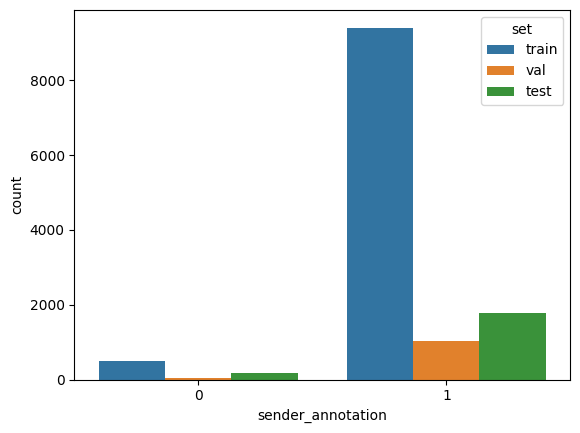

In [ ]:

sns.countplot(data=df_total_filtrado,
              x='sender_annotation',hue='set')

<Axes: xlabel='receiver_annotation', ylabel='count'>

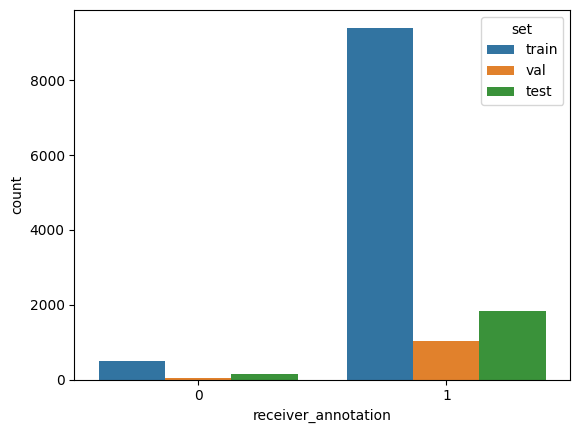

In [ ]:
sns.countplot(data=df_total_filtrado,
              x='receiver_annotation',hue='set')

### Verificando distribuciones en cada conjunto de datos



In [ ]:
df_total_filtrado.query("set=='train'")['sender_annotation'].value_counts(normalize=True)

1    0.950768
0    0.049232
Name: sender_annotation, dtype: float64

In [ ]:
df_total_filtrado.query("set=='val'")['sender_annotation'].value_counts(normalize=True)

1    0.958917
0    0.041083
Name: sender_annotation, dtype: float64

In [ ]:
df_total_filtrado.query("set=='test'")['sender_annotation'].value_counts(normalize=True)

1    0.905727
0    0.094273
Name: sender_annotation, dtype: float64

Se observa que para Sender el conjunto de test no sigue la misma distribución en cuanto a proporción a comparación del conjunto de train y validación. Esto  puede ocasionar que las métricas en el conjunto de test no representen de manera correcta el desempeño general del modelo. Posiblemente la separación de datos mediante estratificación no haya sido óptima


In [ ]:
df_total_filtrado.query("set=='train'")['receiver_annotation'].value_counts(normalize=True)

1    0.95097
0    0.04903
Name: receiver_annotation, dtype: float64

In [ ]:
df_total_filtrado.query("set=='val'")['receiver_annotation'].value_counts(normalize=True)

1    0.965453
0    0.034547
Name: receiver_annotation, dtype: float64

In [ ]:
df_total_filtrado.query("set=='test'")['receiver_annotation'].value_counts(normalize=True)

1    0.926001
0    0.073999
Name: receiver_annotation, dtype: float64

Se observa que para Receiver el conjunto de test no sigue la misma distribución en cuanto a proporción a comparación del conjunto de train y validación. Esto  puede ocasionar que las métricas en el conjunto de test no representen de manera correcta el desempeño general del modelo. Posiblemente la separación de datos mediante estratificación no haya sido óptima

### 2.6 Cantidad de palabras

In [ ]:
def statistics(df,column):

    stat_dic = {'mean':df[column].mean(),
                'std':df[column].std(),
                'median':df[column].median()}

    return stat_dic

In [ ]:
df_total_filtrado.columns

Index(['message', 'sender_annotation', 'receiver_annotation', 'score_delta',
       'game_id', 'set', 'cantidad_palabras'],
      dtype='object')

Text(0.5, 1.0, 'Cantidad de palabras en cada mensaje')

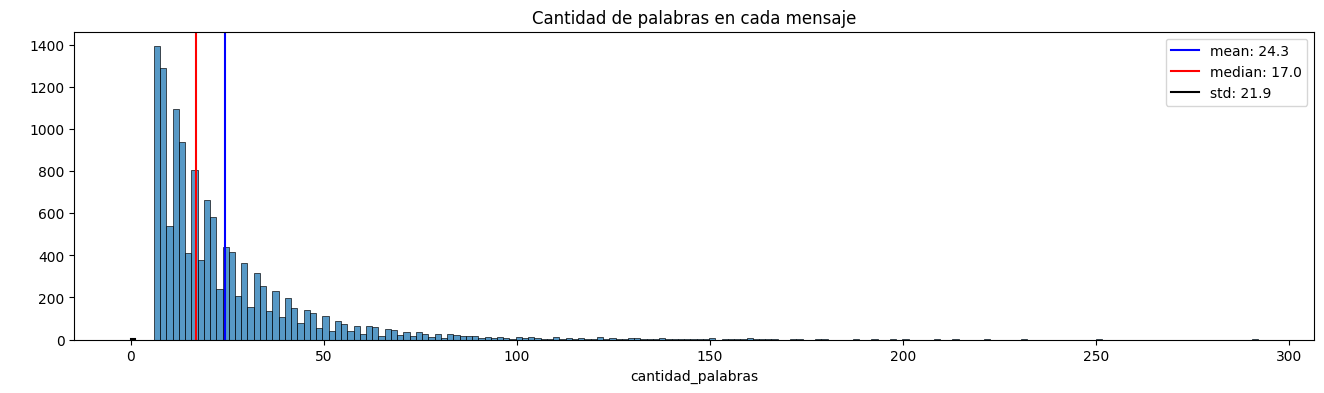

In [ ]:
plt.figure(figsize= (16,4))
sns.histplot(data = df_total_filtrado, x = 'cantidad_palabras')
stat_docs = statistics(df_total_filtrado,column='cantidad_palabras')
plt.axvline(stat_docs['mean'], label = 'mean: %.1f' % stat_docs['mean'] , color = 'blue')
plt.axvline(stat_docs['median'], label = 'median: %.1f' % stat_docs['median'] , color = 'red')
plt.plot([1,1], label = 'std: %.1f' % stat_docs['std'] , color = 'black')

plt.legend()
plt.ylabel(" ")
plt.title("Cantidad de palabras en cada mensaje")

In [ ]:
df_total_filtrado['cantidad_palabras'].describe()

count    12936.000000
mean        24.305272
std         21.902768
min          6.000000
25%         11.000000
50%         17.000000
75%         30.000000
max        292.000000
Name: cantidad_palabras, dtype: float64

La mayoría mitad de los registros poseen menos de 65 palabras mientras que el registro con mayor cantidad de palabras es 587. sin embargo los mensajes siguen estando en el rango de tokens para el finetune de LLM (512 tokens)

In [ ]:
df_total_filtrado.columns

Index(['message', 'sender_annotation', 'receiver_annotation', 'score_delta',
       'game_id', 'set', 'cantidad_palabras'],
      dtype='object')

Text(0.5, 1.0, 'Cantidad de palabras en cada mensaje')

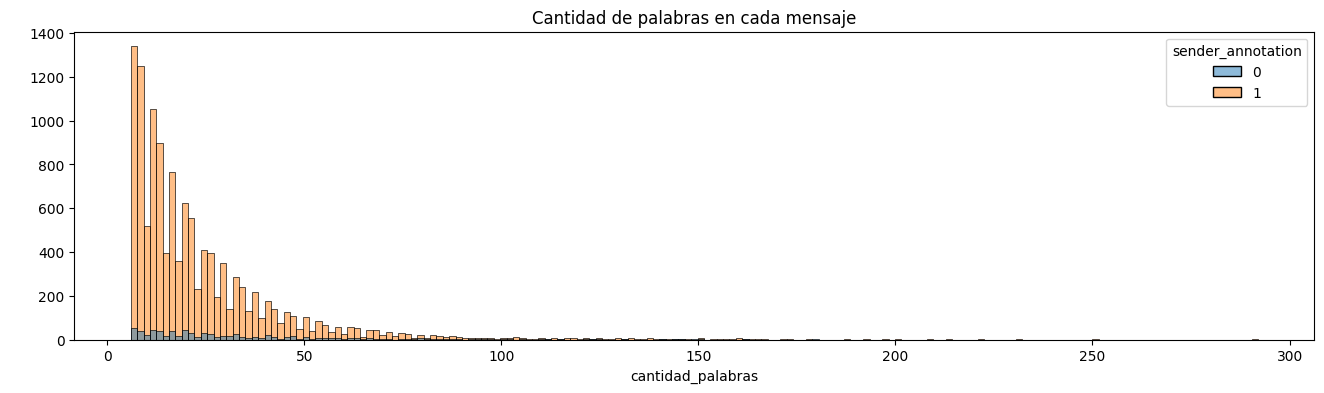

In [ ]:
plt.figure(figsize= (16,4))
sns.histplot(data = df_total_filtrado, x = 'cantidad_palabras',hue='sender_annotation')
stat_docs = statistics(df_total_filtrado,column='cantidad_palabras')
# plt.axvline(stat_docs['mean'], label = 'mean: %.1f' % stat_docs['mean'] , color = 'blue')
# plt.axvline(stat_docs['median'], label = 'median: %.1f' % stat_docs['median'] , color = 'red')
# plt.plot([1,1], label = 'std: %.1f' % stat_docs['std'] , color = 'black')

plt.ylabel(" ")
plt.title("Cantidad de palabras en cada mensaje para Sender")

In [ ]:
df_total_filtrado.columns

Index(['message', 'sender_annotation', 'receiver_annotation', 'score_delta',
       'game_id', 'set', 'cantidad_palabras'],
      dtype='object')

Text(0.5, 1.0, 'Cantidad de palabras en cada mensaje para receiver_annotation')

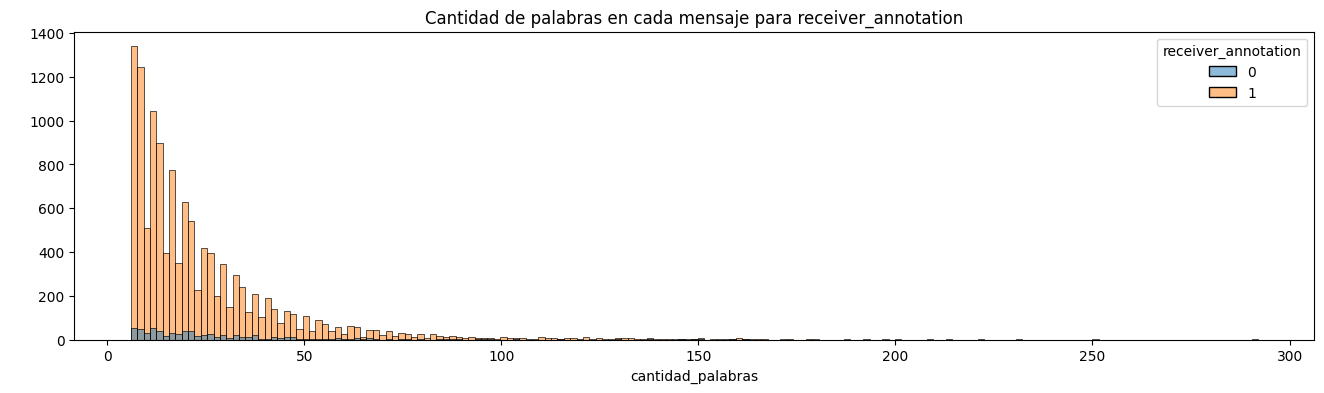

In [ ]:
plt.figure(figsize= (16,4))
sns.histplot(data = df_total_filtrado, x = 'cantidad_palabras',hue='receiver_annotation')
stat_docs = statistics(df_total_filtrado,column='cantidad_palabras')
# plt.axvline(stat_docs['mean'], label = 'mean: %.1f' % stat_docs['mean'] , color = 'blue')
# plt.axvline(stat_docs['median'], label = 'median: %.1f' % stat_docs['median'] , color = 'red')
# plt.plot([1,1], label = 'std: %.1f' % stat_docs['std'] , color = 'black')

plt.ylabel(" ")
plt.title("Cantidad de palabras en cada mensaje para receiver_annotation")

<Figure size 1600x400 with 0 Axes>

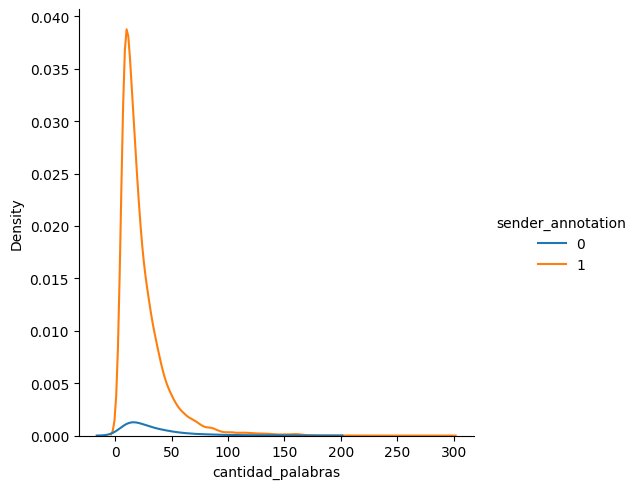

In [ ]:
plt.figure(figsize= (16,4))
sns.displot(data = df_total_filtrado, x = 'cantidad_palabras',
            hue='sender_annotation', kind="kde")

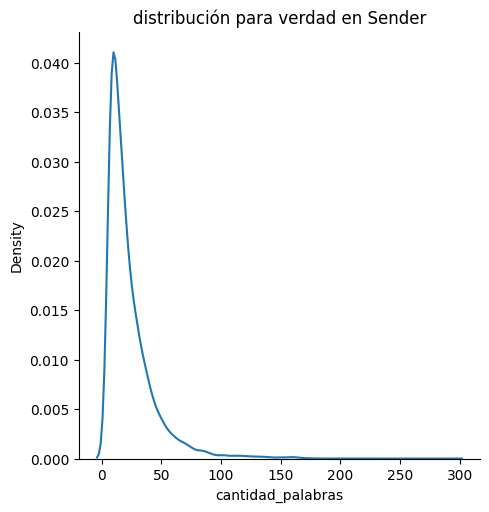

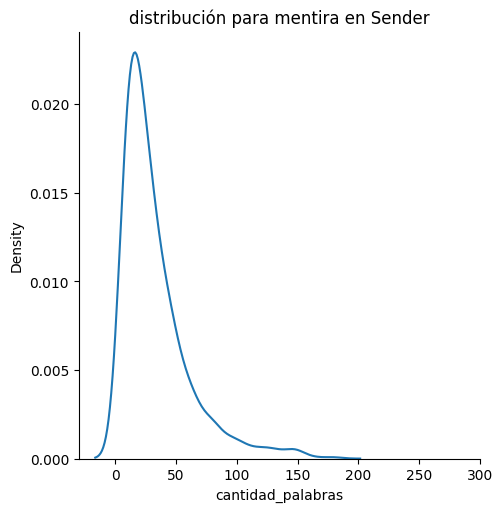

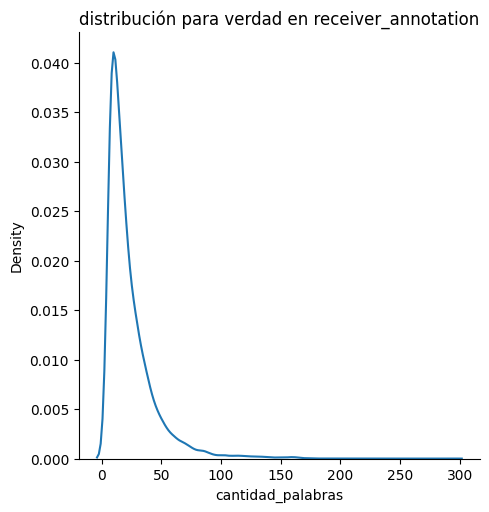

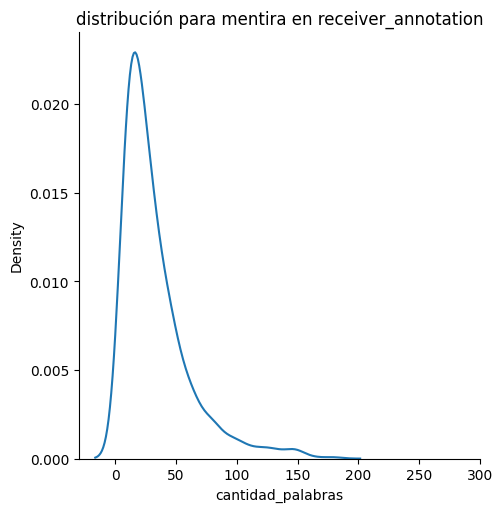

In [ ]:
sns.displot(data = df_total_filtrado[df_total_filtrado['sender_annotation']==1],
            x = 'cantidad_palabras', kind="kde")
plt.title("distribución para verdad en Sender")
plt.show()

sns.displot(data = df_total_filtrado[df_total_filtrado['sender_annotation']==0],
            x = 'cantidad_palabras', kind="kde")
plt.title("distribución para mentira en Sender")
plt.xlim(-30,300)
plt.show()

######################
######################

sns.displot(data = df_total_filtrado[df_total_filtrado['sender_annotation']==1],
            x = 'cantidad_palabras', kind="kde")
plt.title("distribución para verdad en receiver_annotation")
plt.show()

sns.displot(data = df_total_filtrado[df_total_filtrado['sender_annotation']==0],
            x = 'cantidad_palabras', kind="kde")
plt.title("distribución para mentira en receiver_annotation")
plt.xlim(-30,300)
plt.show()

Se observa que la distribución de acuerdo a la cantidad de palabras tanto en mentira como en verdad son muy similares. de tal manera que este atributo no es diferenciador. algunos mensajes al ser muy largos son verdad

## Palabras que más frecuentes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from spacy.lang.en import stop_words

In [ ]:
nlp = spacy.load('en_core_web_sm')

stop_words = stop_words.STOP_WORDS

In [ ]:
len(stop_words)

326

In [ ]:
cv = CountVectorizer(stop_words = list(stop_words) )

In [ ]:
doc_term_matrix = cv.fit_transform(df_total_filtrado['message'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [ ]:
df_count_words = pd.DataFrame(doc_term_matrix.toarray(),
                       columns = cv.get_feature_names_out())

df_count_words.index = df_total_filtrado.index
df_count_words.head()

,01,02,03,05,08,10,100,1000,11,110,...,yuge,yup,yyou,zero,zone,zones,zoning,zrussia,знает,хрен
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_count_words['receiver_annotation'] = df_total_filtrado['receiver_annotation']
df_count_words['sender_annotation'] = df_total_filtrado['sender_annotation']
df_count_words.head(2)

,01,02,03,05,08,10,100,1000,11,110,...,yyou,zero,zone,zones,zoning,zrussia,знает,хрен,receiver_annotation,sender_annotation
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
df_total_filtrado['sender_annotation'].value_counts()

1    12219
0      717
Name: sender_annotation, dtype: int64

### 20 palabras más frecuences

In [ ]:
num_words = 50
df_count_words.sum(axis=0).sort_values(ascending=False).head(num_words)

receiver_annotation    12268
sender_annotation      12219
think                   1635
france                  1588
russia                  1522
italy                   1469
support                 1378
england                 1374
like                    1323
ll                      1295
austria                 1195
germany                 1178
going                   1173
don                     1155
turkey                  1003
want                    1001
good                     813
know                     792
need                     721
fleet                    716
game                     683
turn                     675
sure                     675
work                     668
ve                       665
yeah                     661
way                      644
help                     635
build                    628
let                      625
right                    556
attack                   508
north                    482
army                     478
moves         

In [ ]:
df_sender_true = (
          df_count_words
        .query("sender_annotation==1")
        .sum(axis=0).sort_values(ascending=False)
        .head(num_words)
 )

df_sender_true

sender_annotation      12219
receiver_annotation    11646
france                  1477
think                   1468
italy                   1390
russia                  1390
england                 1263
support                 1262
ll                      1210
like                    1200
austria                 1117
germany                 1085
going                   1062
don                     1046
turkey                   934
want                     897
good                     747
know                     724
fleet                    676
need                     669
yeah                     636
sure                     614
turn                     613
game                     612
work                     609
ve                       606
help                     583
way                      579
let                      576
build                    572
right                    512
attack                   452
army                     451
moves                    450
north         

In [ ]:
df_sender_false = (
  df_count_words
 .query("sender_annotation==0")
 .sum(axis=0).sort_values(ascending=False)
 .head(num_words)
 )

df_sender_false

receiver_annotation    622
think                  167
russia                 132
like                   123
support                116
france                 111
england                111
going                  111
don                    109
want                   104
germany                 93
ll                      85
italy                   79
austria                 78
game                    71
turkey                  69
know                    68
good                    66
way                     65
turn                    62
sure                    61
work                    59
ve                      59
build                   56
attack                  56
help                    52
need                    52
let                     49
right                   44
alliance                44
north                   44
fleet                   40
centers                 38
belgium                 35
plan                    35
trust                   33
getting                 32
s

### Analizando palabras que en común y diferenciadoras

In [ ]:
#palabras diferenciadoras:
set(df_sender_true.index) - set(df_sender_false.index)

{'bounce',
 'fall',
 'moves',
 'probably',
 'sea',
 'sender_annotation',
 'things',
 'try',
 'trying',
 'yeah',
 'year'}

De las 50 palabras que más se repiten. solo 9 están en verdad y no en mentira. lo que quiere decir que solo por palabras es díficil realizar diferenciaciones entre si está mintiendo o no.

Cabe resaltar las palabras probably y ok pues aunque se pensase que alguien está hablando de manera insegura (probably) sería mentira. en análisis dice que es más frecuence escucharlo en verdad. yes y ok también sugieren que se está diciendo la verdad

In [ ]:
#palabras diferenciadoras:
set(df_sender_false.index) - set(df_sender_true.index)

{'centers',
 'getting',
 'haven',
 'mao',
 'munich',
 'play',
 'position',
 'rum',
 'sorry',
 'stab',
 'told'}

De las 50 palabras que más se repiten. solo 9 están en mentira y no en verdad. lo que quiere decir que solo por palabras es díficil realizar diferenciaciones entre si está mintiendo o no. Cabe resaltar las palabras sorry, stab, told. pues si se está disculpando (sorry) o si está hablando de otra persona (told) puede ser mentira

In [ ]:
from wordcloud import WordCloud

In [ ]:
wc = WordCloud(stopwords=stop_words,
               background_color="white",
               colormap="Dark2",
               max_font_size=150,
               random_state=42)

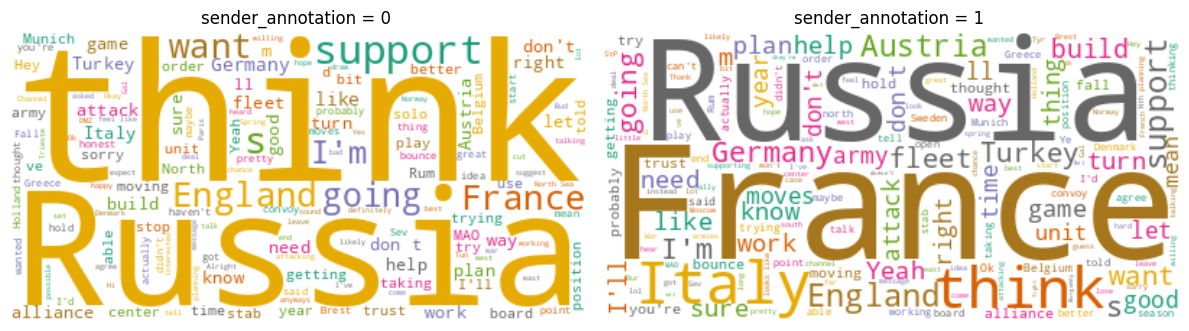

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axes = plt.subplots(nrows=1, ncols=2)
flat_axes = axes.flat

for index in range(2):
    text_data = df_total_filtrado.query("sender_annotation==@index")['message']
    text = " ".join(riesgo for riesgo in text_data)

    flat_axes[index].imshow(wc.generate(text), interpolation="bilinear")
    flat_axes[index].axis("off")

    flat_axes[index].set_title(f"sender_annotation = {index} ")

fig.tight_layout()
plt.show()

### Se observa que las palabras que más se repiten so los paises del juego

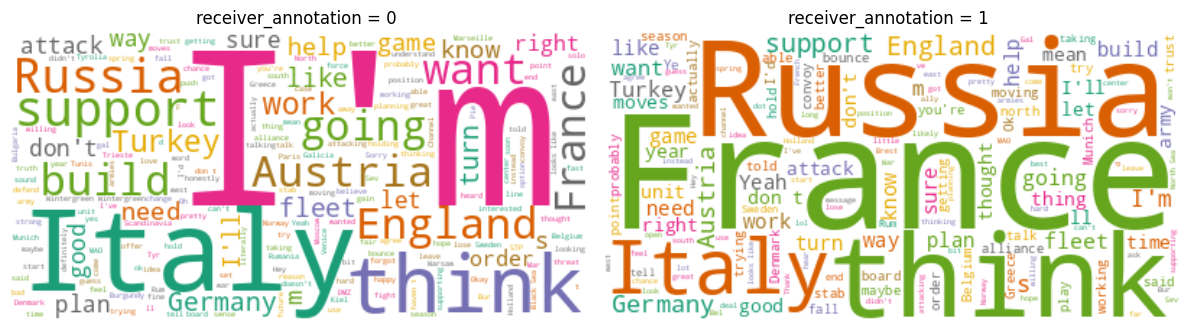

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axes = plt.subplots(nrows=1, ncols=2)
flat_axes = axes.flat

for index in range(2):
    text_data = df_total_filtrado.query("receiver_annotation==@index")['message']
    text = " ".join(riesgo for riesgo in text_data)

    flat_axes[index].imshow(wc.generate(text), interpolation="bilinear")
    flat_axes[index].axis("off")

    flat_axes[index].set_title(f"receiver_annotation = {index} ")

fig.tight_layout()
plt.show()

## 3. Limpieza de datos

### Analizando las palabras menos frecuentes

In [ ]:
df_count_words

,01,02,03,05,08,10,100,1000,11,110,...,yyou,zero,zone,zones,zoning,zrussia,знает,хрен,receiver_annotation,sender_annotation
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
list(df_count_words.columns[:200])

['01',
 '02',
 '03',
 '05',
 '08',
 '10',
 '100',
 '1000',
 '11',
 '110',
 '11th',
 '12',
 '13',
 '13hrs',
 '14',
 '15',
 '16',
 '17',
 '18',
 '1901',
 '1902',
 '1903',
 '1904',
 '1905',
 '1906',
 '1907',
 '1908',
 '1909',
 '1910',
 '1914',
 '1a',
 '1b',
 '1st',
 '20',
 '200',
 '2003',
 '2014',
 '2016',
 '24',
 '25',
 '250',
 '26',
 '2a',
 '2am',
 '2b',
 '2c',
 '2v1',
 '30',
 '30a',
 '30p',
 '358278238675664896',
 '36',
 '3a',
 '3b',
 '3v2',
 '3x',
 '40',
 '45',
 '4d',
 '4v2',
 '4v3',
 '50',
 '530',
 '5538733581926400',
 '5637073032183808',
 '567829259054219275',
 '5727111032078336',
 '5th',
 '613143739954888734',
 '730am',
 '730ish',
 '730pm',
 '7449927',
 '7p',
 '8th',
 '94',
 '945',
 '95',
 '9pm',
 '_____',
 '_and',
 '_anything_',
 '_us_',
 'aaaaaalllllllllll',
 'aaaaany',
 'aars',
 'aassume',
 'abandon',
 'abandoning',
 'abbreviation',
 'abide',
 'abiding',
 'ability',
 'able',
 'abondon',
 'abouts',
 'abreast',
 'abruptly',
 'absolute',
 'absolutely',
 'absolutly',
 'absorb',
 'ab

Realizar eliminación de números, caracteres especiales como _:


In [ ]:
df_count_words.sum(axis=0).sort_values(ascending=True).head(50)

empathetic        1
public            1
pther             1
psychology        1
formally          1
formed            1
formidable        1
forms             1
ps                1
forthcoming       1
forthrightness    1
fortified         1
prussian          1
unnexpected       1
talky             1
unnerves          1
forwarding        1
prudent           1
unnerved          1
foundation        1
fox               1
tall              1
fra               1
fractures         1
fragile           1
frame             1
franc             1
forums            1
forgiveness       1
forgiven          1
publicly          1
folk              1
pursue            1
foment            1
fooled            1
fooling           1
foolish           1
foolproof         1
fools             1
puprose           1
puny              1
footholds         1
punishing         1
forbid            1
forceful          1
unopened          1
punching          1
foreclosing       1
forefront         1
forego            1


In [ ]:
list(df_count_words.columns[-200:])

['weird',
 'weirdly',
 'welcome',
 'welll',
 'welp',
 'welsh',
 'went',
 'weren',
 'wes',
 'west',
 'western',
 'westward',
 'westwards',
 'whadda',
 'whaddya',
 'whales',
 'wham',
 'whatcha',
 'whatev',
 'whatrecyou',
 'whats',
 'whatsoever',
 'whcih',
 'wheedled',
 'wheel',
 'whelp',
 'whet',
 'whew',
 'whichever',
 'whild',
 'whipe',
 'whispered',
 'whittling',
 'whoa',
 'wholeheartedly',
 'wholly',
 'whoops',
 'whoppers',
 'whore',
 'whupping',
 'wick',
 'wide',
 'widely',
 'wierd',
 'wife',
 'wild',
 'wildcard',
 'willfully',
 'willing',
 'willingly',
 'willingness',
 'win',
 'wind',
 'window',
 'winds',
 'wines',
 'wink',
 'winner',
 'winners',
 'winning',
 'wins',
 'winter',
 'wintergreen',
 'wipe',
 'wiped',
 'wiping',
 'wire',
 'wires',
 'wirh',
 'wise',
 'wisely',
 'wish',
 'wished',
 'wishes',
 'wishful',
 'wishing',
 'wishy',
 'witchcraft',
 'withdraw',
 'withdrawal',
 'withdrawing',
 'withdrew',
 'withing',
 'witness',
 'witnessed',
 'wizard',
 'wmed',
 'woah',
 'woke',
 '

##  3.2 Ejecución de limpieza

In [ ]:
import re
def limpiar_texto_1(texto):
    #convertiendo a minúsculas

    texto = texto.lower()

    #Eliminamos los caracteres especiales
    texto = re.sub(r'_', ' ', texto)
    texto = re.sub(r'll', ' ', texto)

    #eliminando sitios web
    pattern  = re.compile(r'(htt)\S+')
    texto = re.sub(pattern = pattern, repl= '',string = texto )
    pattern  = re.compile(r'(www)\S+')
    texto = re.sub(pattern = pattern, repl= '',string = texto )

    #Eliminación correos
    pattern = re.compile(r'\S*@\S*\s?')
    texto = re.sub(pattern = pattern, repl= '',string = texto )


    #eliminando números
    pattern  = re.compile(r'\w*\d\w*')
    texto = re.sub(pattern = pattern, repl= '',string = texto )
    pattern  = re.compile(r'\d+')
    texto = re.sub(pattern = pattern, repl= '',string = texto )


    #Sustituir los espacios en blanco en uno solo
    pattern  = re.compile(r'\s+')
    texto  = re.sub(pattern = pattern, repl= ' ',string = texto)

    #Eliminando espacios iniciales y finales
    texto = texto.rstrip().lstrip()
    return texto

#####################################################
#####################################################
#####################################################
#####################################################
#####################################################
#####################################################



def limpiar_datos(tipo_limpieza, df,datos):
    print("2.")
    if tipo_limpieza =='limpieza_1':
        print("limpieza_1 usada")
        return df[datos].apply(limpiar_texto_1)

    elif tipo_limpieza =='no':
        print("no limpieza usada")
        return df[datos]


In [ ]:
df_total_filtrado['input'] = limpiar_datos(tipo_limpieza='limpieza_1',
                                           df = df_total_filtrado,
                                           datos = 'message')

2.
limpieza_1 usada


<ipython-input-94-2be8925916e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_filtrado['input'] = limpiar_datos(tipo_limpieza='limpieza_1',


In [ ]:
df_total_filtrado.head(2)

,message,sender_annotation,receiver_annotation,score_delta,game_id,set,cantidad_palabras,input
0,Germany!\n\nJust the person I want to speak wi...,1,1,0,1,train,84,germany! just the person i want to speak with....
1,"You've whet my appetite, Italy. What's the sug...",1,1,0,1,train,8,"you've whet my appetite, italy. what's the sug..."


In [ ]:
cv_clean = CountVectorizer(stop_words = list(stop_words) )

doc_term_matrix_clean = cv_clean.fit_transform(df_total_filtrado['input'])
df_count_words = pd.DataFrame(doc_term_matrix_clean.toarray(),
                       columns = cv_clean.get_feature_names_out())

df_count_words.index = df_total_filtrado.index
df_count_words.head()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


,aaaaaa,aaaaany,aars,aassume,abandon,abandoning,abbreviation,abic,abide,abiding,...,yuge,yup,yyou,zero,zone,zones,zoning,zrussia,знает,хрен
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Entrenamiento de modelo


In [ ]:
%%capture
!pip install transformers[torch]

In [ ]:
%%capture
!pip install datasets

In [ ]:
import torch
from datasets import Dataset, DatasetDict

In [ ]:
df_total_para_modelo = df_total_filtrado[['message','sender_annotation','receiver_annotation','set']]

##  4.2 Submuestreo

Debido al desbalanceo de la clases se realiza submuestreo del conjunto de train y validation con el fin de incentivar más al modelo a predecir la mentira (la clase subrepresentada)

In [ ]:
def undersample(df_temp_train,columna, razon_neg_pos=0.1,activate_undersample=True):
    '''
    Función que realiza submuestreo de los datos con el fin de mitigar el sobreajuste
    en el entrenamiento. La variable objetivo debe de estar almacenada en una columna
    llamada label

    df_temp: dataframe utilizado
    columna: columna de texto (input)
    razon_neg_pos: razón valores negativos/valores positivos que se requiere
    activate_undersample: Activa o no el submuestreo
    '''
    random_state = 42
    df_temp_train_copy = df_temp_train.copy()
    y_train = df_temp_train_copy[columna].values.reshape(-1,1)
    df_temp_train_copy['id_elemento'] = df_temp_train_copy.index

    #calculando la cantidad de positivos para la razón_neg_pos dada
    diccionario_proporcion = df_temp_train_copy['label'].value_counts().to_dict()
    muestreo = int(diccionario_proporcion[0]/razon_neg_pos)
    print(diccionario_proporcion[0])
    print("muestreo positivos",muestreo )


    if activate_undersample:
        #adjuntando a el df_copy el target para hacer la separación
        df_temp_train_copy['clase'] = y_train.reshape(-1)

        #separando df en verdad y no_verdad
        df_temp_train_copy_no_verdad = df_temp_train_copy[df_temp_train_copy['clase'] ==0]
        df_temp_train_copy_si_verdad = df_temp_train_copy[df_temp_train_copy['clase'] ==1]
        cantidad_no_verdad             = df_temp_train_copy_no_verdad.shape[0]
        print("cantidad_no_verdad",cantidad_no_verdad)

        #submuestreando los mensajes verdaderos
        df_temp_train_copy_si_verdad_sampled = df_temp_train_copy_si_verdad.sample(muestreo, random_state = random_state)

        #concatenando los registros si verdad (submuestrados) y con no verdad (originales)
        df_temp_train_resampled = pd.concat((df_temp_train_copy_no_verdad,df_temp_train_copy_si_verdad_sampled))
        df_temp_train_resampled = df_temp_train_resampled.sample(muestreo+cantidad_no_verdad, random_state = random_state)

        print("shape luego de realizar submuestreo ",df_temp_train_resampled.shape)
        print("razon neg/pos", cantidad_no_verdad/muestreo *100 )

        return df_temp_train_resampled.drop('clase',axis=1).drop('id_elemento',axis=1)
    else:
        df_temp_train_resampled = df_temp_train_copy

    return df_temp_train_resampled

## Modelo para sender_annotation

In [ ]:
df_total_para_modelo

,message,sender_annotation,receiver_annotation,set
0,Germany!\n\nJust the person I want to speak wi...,1,1,train
1,"You've whet my appetite, Italy. What's the sug...",1,1,train
3,It seems like there are a lot of ways that cou...,1,1,train
7,"Sorry Italy I've been away doing, um, German t...",1,1,train
8,"I don't think I'm ready to go for that idea, h...",1,0,train
...,...,...,...,...
2735,The only issue would be a retreat to Greece or...,1,1,test
2736,"Interesting, I didn't mean to take Naples- I f...",0,1,test
2737,Interesting choice to move to Albania as it me...,1,1,test
2739,"This game is over, spending more than 2 minute...",1,1,test


In [ ]:
df_total_para_modelo_sender = df_total_para_modelo[['message','sender_annotation','set']]

In [ ]:
df_total_para_modelo_sender.columns= ['text','label','set']

In [ ]:
df_train_para_modelo = df_total_para_modelo_sender.query("set=='train'").drop('set',axis=1)
df_val_para_modelo   = df_total_para_modelo_sender.query("set=='val'").drop('set',axis=1)
df_test_para_modelo  = df_total_para_modelo_sender.query("set=='test'").drop('set',axis=1)

### Solamente se submuestrea el conjunto de train y validation, el test se deja intacto

In [ ]:
razon_neg_pos = 0.3

df_train_para_modelo_submuestreo = undersample(df_temp_train=df_train_para_modelo,
                                               columna='label',
                                               razon_neg_pos=razon_neg_pos,
                                               activate_undersample=True)

df_val_para_modelo_submuestreo = undersample(df_temp_train=df_val_para_modelo,
                                               columna='label',
                                               razon_neg_pos=razon_neg_pos,
                                               activate_undersample=True)

487
muestreo positivos 1623
cantidad_no_verdad 487
shape luego de realizar submuestreo  (2110, 4)
razon neg/pos 30.006161429451634
44
muestreo positivos 146
cantidad_no_verdad 44
shape luego de realizar submuestreo  (190, 4)
razon neg/pos 30.136986301369863


In [ ]:
ds_original= DatasetDict(
      {
      "train": Dataset.from_pandas(df_train_para_modelo.reset_index(drop=True)  ) ,
      "valid": Dataset.from_pandas(df_val_para_modelo.reset_index(drop=True)),
      "test": Dataset.from_pandas(df_total_para_modelo.query("set=='test'").drop('set',axis=1).reset_index(drop=True))
      }
      )

In [ ]:
ds_subsample = DatasetDict(
      {
      "train": Dataset.from_pandas(df_train_para_modelo_submuestreo.reset_index(drop=True)  ) ,
      "valid": Dataset.from_pandas(df_val_para_modelo_submuestreo.reset_index(drop=True)),
      "test": Dataset.from_pandas(df_total_para_modelo.query("set=='test'").drop('set',axis=1).reset_index(drop=True))
      }
      )

In [ ]:
ds_subsample

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2110
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 190
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1973
    })
})

## 4.3 Entrenamiento RoBERTa Ironia

### 4.3.1 Embedding de texto

In [ ]:
from transformers import AutoTokenizer

In [ ]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='irony'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
model_ckpt = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
  '''
  Función para tokenizar todo el dataset
  padding: Para que en las oraciones que poseen menor
  tamaño que el máximo se les agregue 0's para que todas
  queden del mismo tamaño

  truncation: para que corte los valores mayores a 512 tokesn
  '''
  return tokenizer(batch['text'],
                   padding=True,
                   truncation = True,
                   max_length=512)


In [ ]:
ds_subsample_encoded = ds_subsample.map(tokenize,
                  batched = True,
                  batch_size = None)

Map:   0%|          | 0/2110 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/1973 [00:00<?, ? examples/s]

In [ ]:
ds_subsample_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2110
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 190
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1973
    })
})

In [ ]:
ds_encoded_original = ds_original.map(tokenize,
                      batched = True,
                      batch_size = None)

Map:   0%|          | 0/9892 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

Map:   0%|          | 0/1973 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModel,Trainer, TrainingArguments,AutoModelForSequenceClassification

In [ ]:
device = torch.device('cuda' if
                      torch.cuda.is_available() else 'cpu')

In [ ]:
#adjunto dos neuronas para realizar la clasificación

num_labels = 2
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels = num_labels)
        .to(device))

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import (f1_score,recall_score, precision_score,
                             classification_report,accuracy_score)

In [ ]:
#Métricas de clasificación

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  #argmax(-1) significa que va a realizar
  #la búsqueda del argumento máximo en el
  #último axis que sale cuando se ejecuta
  #.shape

  f1        = f1_score(labels, preds,average = 'macro')
  recall    = recall_score(labels, preds,average = 'macro')
  precision = precision_score(labels, preds ,average = 'macro')
  acc       = accuracy_score(labels, preds)

  return {'accuracy': acc, 'f1_score': f1,
          'recall':recall, 'precision': precision}

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
batch_size = 16
logging_steps = len(ds_subsample_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

logging_steps,model_name

(131, 'cardiffnlp/twitter-roberta-base-irony-finetuned-emotion')

In [ ]:
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  disable_tqdm=False,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='f1_score',
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  logging_strategy="epoch",
                                  save_total_limit=1
                                  )

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_subsample_encoded["train"],
                  eval_dataset=ds_subsample_encoded["valid"],
                  tokenizer=tokenizer)

In [ ]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.557600,0.504118,0.757895,0.470303,0.509029,0.552536
2,0.481100,0.517305,0.773684,0.619274,0.606631,0.666061
3,0.346500,0.637575,0.763158,0.610283,0.599782,0.645649
4,0.215400,0.748569,0.752632,0.609617,0.600872,0.631467
5,0.132600,0.902290,0.736842,0.611229,0.606476,0.618421


CPU times: user 11min 10s, sys: 14.4 s, total: 11min 24s
Wall time: 12min 59s


TrainOutput(global_step=660, training_loss=0.34664527719671073, metrics={'train_runtime': 779.019, 'train_samples_per_second': 13.543, 'train_steps_per_second': 0.847, 'total_flos': 2033072485875000.0, 'train_loss': 0.34664527719671073, 'epoch': 5.0})

### Realizando las predicciones en el dataset original

In [ ]:
preds_train = trainer.predict(ds_encoded_original["train"])
preds_valid = trainer.predict(ds_encoded_original["valid"])
preds_test  = trainer.predict(ds_encoded_original["test"])

In [ ]:
y_train = df_train_para_modelo['label'].values
y_valid = df_val_para_modelo['label'].values
y_test  = df_total_filtrado.query("set=='test'")['sender_annotation'].values

y_preds_train = np.argmax(preds_train.predictions, axis=1)
y_preds_val   = np.argmax(preds_valid.predictions, axis=1)
y_preds_test  = np.argmax(preds_test.predictions, axis=1)

print(classification_report(y_train,y_preds_train))
print(classification_report(y_valid,y_preds_val))
print(classification_report(y_test,y_preds_test))

              precision    recall  f1-score   support

           0       0.24      0.62      0.35       487
           1       0.98      0.90      0.94      9405

    accuracy                           0.89      9892
   macro avg       0.61      0.76      0.64      9892
weighted avg       0.94      0.89      0.91      9892

              precision    recall  f1-score   support

           0       0.12      0.30      0.17        44
           1       0.97      0.90      0.93      1027

    accuracy                           0.88      1071
   macro avg       0.54      0.60      0.55      1071
weighted avg       0.93      0.88      0.90      1071

              precision    recall  f1-score   support

           0       0.21      0.26      0.23       186
           1       0.92      0.89      0.91      1787

    accuracy                           0.84      1973
   macro avg       0.56      0.58      0.57      1973
weighted avg       0.85      0.84      0.84      1973



In [ ]:
trainer.save_model("/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica/RoBERTa_irony_5_sender")

## Análisis del error

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels, normalize="true"):

  cm = confusion_matrix(y_true, y_preds, normalize=normalize)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Confusion matrix")
  plt.show()

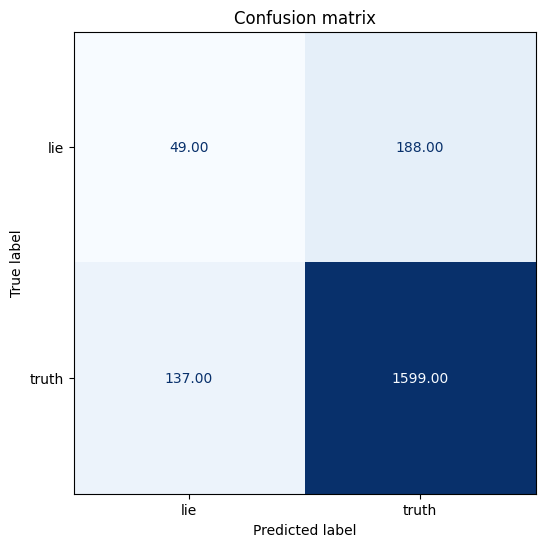

In [ ]:
plot_confusion_matrix(y_test, y_preds_test,
                      labels=['lie','truth'],
                      normalize=None)

### Encontrando mensajes con valor de función de pérdida mayor

In [ ]:
from torch.nn.functional import cross_entropy

In [ ]:
def forward_pass_with_label(batch):

  # Place all input tensors on the same device as the model
  inputs = {key:value.to(device) for
            key,value in batch.items()
            if key in tokenizer.model_input_names }

  with torch.no_grad():
    output = model(**inputs)
    #se le pasan los labels,máscaras,etc.

    pred_label = torch.argmax(output.logits, axis=-1)
    #encontrando el label con el argumento máximo

    loss = cross_entropy(output.logits,
                         batch["label"].to(device),
                         reduction="none")

    return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [ ]:
columns = ["input_ids", "attention_mask", "label"]

ds_subsample_encoded.set_format("torch",
                 columns= columns)

#se le pasa el argumento de columns
#para que solo tome estos ya que no es
#necesario la columna text

In [ ]:
ds_subsample_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2110
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 190
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1973
    })
})

In [ ]:
# Compute loss values

ds_subsample_encoded["test"] = ds_subsample_encoded["test"].map(
                forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/1973 [00:00<?, ? examples/s]

In [ ]:
ds_subsample_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]

df_test_error = ds_subsample_encoded["test"][:][cols]

In [ ]:
df_test_error.head(1)

,text,label,predicted_label,loss
0,"Hi Italy! Just opening up communication, and I...",1,1,0.51029


### Valores de coste más grandes

In [ ]:
(df_test_error.query("label==0")
.sort_values("loss", ascending=False)
.head(50)
)

,text,label,predicted_label,loss
1725,I had to justify not going NC somehow,0,1,2.876040
991,Btw have you talked to Italy?,0,1,2.622984
1768,Is he giving you Belgium right now?,0,1,2.585946
1421,There arn't really any other options,0,1,2.557947
881,idk if it's true just letting u know since wer...,0,1,2.509302
1044,Yeah. Like I said seems England wouldn't be so...,0,1,2.502520
166,More than expects: they’re already explicitly ...,0,1,2.492233
1606,I appreciate you bringing up concerns: I would...,0,1,2.489684
1865,Thanks for that- it ultimately wasn't necessar...,0,1,2.486292
1077,Oh sorry. I've been real busy,0,1,2.437618


Se observa que los mensajes calificados como mentira y que el modelo predijo como verdad un humano tampoco hubiese sido capaz de realizar una identificación pues mensjaes como:

* Do you have any Intel on Germany or England? es calificado como mentira pero es una pregunta
* 	Oh sorry. I've been real busy. Es subjetivo
* There arn't really any other options.  Es imposible de conocer sin un contexto previo


### Valores de coste más pequeños

In [ ]:
(df_test_error.query("label==0")
.sort_values("loss", ascending=True)
.head(50)
)

,text,label,predicted_label,loss
1419,I think we might be able to do,0,0,0.172374
1371,I would like to work with you. I realize that ...,0,0,0.237414
1061,I think we could work together but I definitel...,0,0,0.239659
1644,I really hope you don't betray me as I think t...,0,0,0.292031
1038,It looks like we've already got ourselves a ra...,0,0,0.292921
961,Alright. We'll leave it for now. I was hoping ...,0,0,0.318243
1391,Well... that was harsh. Let me just put a few ...,0,0,0.318794
1282,"Again, sorry for the stab. In hindsight, I can...",0,0,0.322794
1243,Damn- I seriously did not intend to take Tries...,0,0,0.328116
1040,Has he contacted you? And I'm not sure. I don'...,0,0,0.347124


from matplotlib import pyplot as plt
_df_0['predicted_label'].plot(kind='hist', bins=20, title='predicted_label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['loss'].plot(kind='hist', bins=20, title='loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='predicted_label', y='loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['predicted_label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'predicted_label'}, axis=1)
              .sort_values('predicted_label', ascending=True))
  xs = counted['predicted_label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('predicted_label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('predicted_label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['loss']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'loss'}, axis=1)
              .sort_values('loss', ascending=True))
  xs = counted['loss']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('loss')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['predicted_label'].plot(kind='line', figsize=(8, 4), title='predicted_label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

### Se observa que los mensajes que calificados como mentira y correctamente predichos por el modelo tienen características que son identificadas por los psicólogo para la mentira como:

* Palabras como: sorry, think, really, should


In [ ]:
df_test_error.to_csv("/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica/RoBERTa_irony_5/df_test_error.csv")

## Modelo para receiver annotation

In [ ]:
df_total_para_modelo_receiver = df_total_para_modelo[['message','receiver_annotation','set']]

In [ ]:
df_total_para_modelo_receiver.columns= ['text','label','set']

In [ ]:
df_train_para_modelo = df_total_para_modelo_receiver.query("set=='train'").drop('set',axis=1)
df_val_para_modelo   = df_total_para_modelo_receiver.query("set=='val'").drop('set',axis=1)
df_test_para_modelo  = df_total_para_modelo_receiver.query("set=='test'").drop('set',axis=1)

In [ ]:
razon_neg_pos = 0.3

df_train_para_modelo_submuestreo = undersample(df_temp_train=df_train_para_modelo,
                                               columna='label',
                                               razon_neg_pos=razon_neg_pos,
                                               activate_undersample=True)

df_val_para_modelo_submuestreo = undersample(df_temp_train=df_val_para_modelo,
                                               columna='label',
                                               razon_neg_pos=razon_neg_pos,
                                               activate_undersample=True)

485
muestreo positivos 1616
cantidad_no_verdad 485
shape luego de realizar submuestreo  (2101, 4)
razon neg/pos 30.012376237623762
37
muestreo positivos 123
cantidad_no_verdad 37
shape luego de realizar submuestreo  (160, 4)
razon neg/pos 30.081300813008134


In [ ]:
ds_original= DatasetDict(
      {
      "train": Dataset.from_pandas(df_train_para_modelo.reset_index(drop=True)  ) ,
      "valid": Dataset.from_pandas(df_val_para_modelo.reset_index(drop=True)),
      "test": Dataset.from_pandas(df_test_para_modelo.reset_index(drop=True))
      }
      )

ds_original

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9892
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1071
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1973
    })
})

In [ ]:
ds_subsample = DatasetDict(
      {
      "train": Dataset.from_pandas(df_train_para_modelo_submuestreo.reset_index(drop=True)  ) ,
      "valid": Dataset.from_pandas(df_val_para_modelo_submuestreo.reset_index(drop=True)),
      "test": Dataset.from_pandas(df_total_para_modelo_receiver.query("set=='test'").drop('set',axis=1).reset_index(drop=True))
      }
      )

In [ ]:
ds_subsample

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2101
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1973
    })
})

In [ ]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='irony'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
model_ckpt = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
ds_encoded_original = ds_original.map(tokenize,
                      batched = True,
                      batch_size = None)

Map:   0%|          | 0/9892 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

Map:   0%|          | 0/1973 [00:00<?, ? examples/s]

In [ ]:
ds_subsample_encoded = ds_subsample.map(tokenize,
                  batched = True,
                  batch_size = None)

Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/1973 [00:00<?, ? examples/s]

In [ ]:
num_labels = 2

model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels = num_labels)
        .to(device))

In [ ]:
batch_size = 16
logging_steps = len(ds_subsample_encoded["train"]) // batch_size
model_name = f"{model_ckpt}_finetuned_emotion_receiver"

logging_steps,model_name

(131, 'cardiffnlp/twitter-roberta-base-irony_finetuned_emotion_receiver')

In [ ]:
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  disable_tqdm=False,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='f1_score',
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  logging_strategy="epoch",
                                  save_total_limit=1
                                  )

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_subsample_encoded["train"],
                  eval_dataset=ds_subsample_encoded["valid"],
                  tokenizer=tokenizer)

In [ ]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.568600,0.549645,0.768750,0.434629,0.500000,0.384375
2,0.477900,0.559871,0.762500,0.517613,0.533729,0.612951
3,0.347200,0.645726,0.737500,0.599141,0.593056,0.611477
4,0.202200,0.858275,0.750000,0.540758,0.544496,0.593103
5,0.105800,1.007453,0.743750,0.584784,0.578225,0.609069


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 9min 59s, sys: 14 s, total: 10min 13s
Wall time: 12min 47s


TrainOutput(global_step=660, training_loss=0.34033842231288103, metrics={'train_runtime': 766.3364, 'train_samples_per_second': 13.708, 'train_steps_per_second': 0.861, 'total_flos': 2024400612712500.0, 'train_loss': 0.34033842231288103, 'epoch': 5.0})

In [ ]:
preds_train = trainer.predict(ds_encoded_original["train"])
preds_valid = trainer.predict(ds_encoded_original["valid"])
preds_test  = trainer.predict(ds_encoded_original["test"])

In [ ]:
y_train = df_train_para_modelo['label'].values
y_valid = df_val_para_modelo['label'].values
y_test  = df_total_filtrado.query("set=='test'")['receiver_annotation'].values

y_preds_train = np.argmax(preds_train.predictions, axis=1)
y_preds_val   = np.argmax(preds_valid.predictions, axis=1)
y_preds_test  = np.argmax(preds_test.predictions, axis=1)

print(classification_report(y_train,y_preds_train))
print(classification_report(y_valid,y_preds_val))
print(classification_report(y_test,y_preds_test))

              precision    recall  f1-score   support

           0       0.23      0.89      0.37       485
           1       0.99      0.85      0.92      9407

    accuracy                           0.85      9892
   macro avg       0.61      0.87      0.64      9892
weighted avg       0.96      0.85      0.89      9892

              precision    recall  f1-score   support

           0       0.06      0.32      0.10        37
           1       0.97      0.81      0.88      1034

    accuracy                           0.79      1071
   macro avg       0.51      0.57      0.49      1071
weighted avg       0.94      0.79      0.86      1071

              precision    recall  f1-score   support

           0       0.13      0.33      0.19       146
           1       0.94      0.83      0.88      1827

    accuracy                           0.79      1973
   macro avg       0.54      0.58      0.53      1973
weighted avg       0.88      0.79      0.83      1973



In [ ]:
trainer.save_model("/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica/RoBERTa_irony_5_receiver")

### Análisis del error

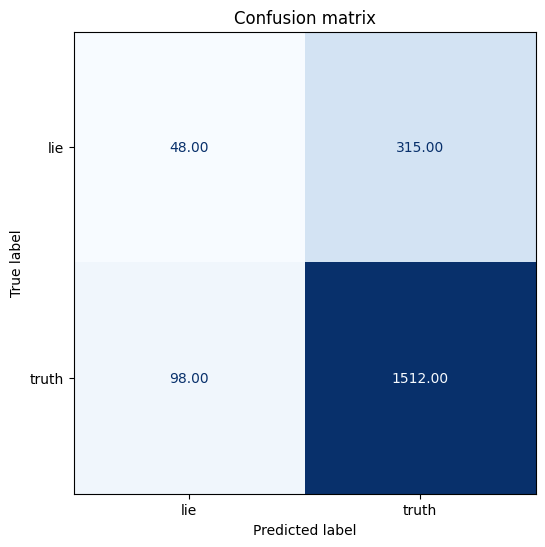

In [ ]:
plot_confusion_matrix(y_test, y_preds_test,
                      labels=['lie','truth'],
                      normalize=None)

In [ ]:
def forward_pass_with_label(batch):

  # Place all input tensors on the same device as the model
  inputs = {key:value.to(device) for
            key,value in batch.items()
            if key in tokenizer.model_input_names }

  with torch.no_grad():
    output = model(**inputs)
    #se le pasan los labels,máscaras,etc.

    pred_label = torch.argmax(output.logits, axis=-1)
    #encontrando el label con el argumento máximo

    loss = cross_entropy(output.logits,
                         batch["label"].to(device),
                         reduction="none")

    return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [ ]:
columns = ["input_ids", "attention_mask", "label"]

ds_subsample_encoded.set_format("torch",
                 columns= columns)

#se le pasa el argumento de columns
#para que solo tome estos ya que no es
#necesario la columna text

In [ ]:
# Compute loss values

ds_subsample_encoded["test"] = ds_subsample_encoded["test"].map(
                forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/1973 [00:00<?, ? examples/s]

In [ ]:
ds_subsample_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]

df_test_error = ds_subsample_encoded["test"][:][cols]

In [ ]:
(df_test_error.query("label==0")
.sort_values("loss", ascending=False)
.head(50)
)

,text,label,predicted_label,loss
1062,So let's work something out. What's the game p...,0,1,4.595338
962,Hey what's the deal with France? They're talki...,0,1,4.536756
1760,Lol Germany is mad at me I don't think I'm gon...,0,1,4.366002
64,"Oh, I'm fine, and highly amused\nI wouldn't mi...",0,1,4.150870
1460,Turkey's builds are looking pretty good for you,0,1,4.120203
1278,Stuff like the bounce in English Channel,0,1,4.115598
874,What are you planning doing this turn?,0,1,4.088076
1905,Russia seems to be well defended but not too s...,0,1,3.974828
1857,"I really need a build right now, and even thou...",0,1,3.895519
1111,They told me they are interested in working wi...,0,1,3.885252


Se observa que los mensajes calificados como mentira y que el modelo predijo como verdad un humano tampoco hubiese sido capaz de realizar una identificación pues mensjaes como:

* So let's work something out. What's the game plan? es calificado como mentira pero es una pregunta
* 	Oh sorry. I've been real busy. Es subjetivo
* There arn't really any other options.  Es imposible de conocer sin un contexto previo


In [208]:
(df_test_error.query("label==0")
.sort_values("loss", ascending=True)
.head(50)
)

,text,label,predicted_label,loss
1061,I think we could work together but I definitel...,0,0,0.074790
1369,This is where we need to trust each other. I w...,0,0,0.110028
1682,In the south you can easily take Serbia and Bu...,0,0,0.115802
1311,Stabbing either you or France would get me rig...,0,0,0.122114
1366,I did not have enough time to change my orders...,0,0,0.134227
1409,"If you give me berlin back, I can support you ...",0,0,0.136649
510,"As we move forward, once I start taking center...",0,0,0.143858
959,That's fair. I'm personally pro-leave Sweden t...,0,0,0.143989
1241,"Ngl, completely forgot about it being a dmz. I...",0,0,0.145673
1964,I'm building an army in Marseilles for example,0,0,0.155411


### Se observa que los mensajes que calificados como mentira y correctamente predichos por el modelo tienen características que son identificadas por los psicólogo para la mentira como:

* Palabras como: sorry, think, really, should, not sure, completely



# Experimentos

## Modelo RoBERTa + pesos

Como se está enfrentando a un problema de muestras desbalanceadas se agregan pesos a la función de coste para priorizar las predicciones de las mentiras

In [ ]:
from torch import nn

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  #argmax(-1) significa que va a realizar
  #la búsqueda del argumento máximo en el
  #último axis que sale cuando se ejecuta
  #.shape

  f1        = f1_score(labels, preds,average = 'macro')
  recall    = recall_score(labels, preds,average = 'macro')
  precision = precision_score(labels, preds ,average = 'macro')
  acc       = accuracy_score(labels, preds)

  return {'accuracy': acc, 'f1_score': f1,
          'recall':recall, 'precision': precision}

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        peso_verdad  = 1.0
        peso_mentira = 4.0
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([peso_mentira,peso_verdad], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
custom_trainer = CustomTrainer(
    model=model,tokenizer=tokenizer,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["valid"],
    compute_metrics=compute_metrics
)

In [ ]:
custom_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.391100,1.295215,0.759259,0.608641,0.598795,0.639266
2,0.242200,2.407900,0.763889,0.604977,0.594819,0.645123
3,0.235200,2.555288,0.754630,0.589486,0.581807,0.625207
4,0.174800,3.189969,0.768519,0.563672,0.562892,0.646465
5,0.066400,3.053501,0.750000,0.593589,0.585783,0.620924


TrainOutput(global_step=735, training_loss=0.2219262389098706, metrics={'train_runtime': 1163.4401, 'train_samples_per_second': 10.091, 'train_steps_per_second': 0.632, 'total_flos': 3088923789926400.0, 'train_loss': 0.2219262389098706, 'epoch': 5.0})

In [ ]:
preds_train = custom_trainer.predict(ds_encoded["train"])
preds_valid = custom_trainer.predict(ds_encoded["valid"])
preds_test  = custom_trainer.predict(ds_encoded["test"])

In [ ]:
y_train = df_train_para_modelo_submuestreo['label'].values
y_valid = df_val_para_modelo_submuestreo['label'].values
y_test  = df_total_filtrado.query("set=='test'")['sender_annotation'].values

y_preds_train = np.argmax(preds_train.predictions, axis=1)
y_preds_val   = np.argmax(preds_valid.predictions, axis=1)
y_preds_test  = np.argmax(preds_test.predictions, axis=1)

print(classification_report(y_train,y_preds_train))
print(classification_report(y_valid,y_preds_val))
print(classification_report(y_test,y_preds_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       542
           1       0.98      0.96      0.97      1806

    accuracy                           0.95      2348
   macro avg       0.93      0.94      0.94      2348
weighted avg       0.96      0.95      0.95      2348

              precision    recall  f1-score   support

           0       0.47      0.30      0.37        50
           1       0.81      0.90      0.85       166

    accuracy                           0.76       216
   macro avg       0.64      0.60      0.61       216
weighted avg       0.73      0.76      0.74       216

              precision    recall  f1-score   support

           0       0.12      0.17      0.14       207
           1       0.92      0.89      0.90      2264

    accuracy                           0.83      2471
   macro avg       0.52      0.53      0.52      2471
weighted avg       0.85      0.83      0.84      2471



In [ ]:
custom_trainer.save_model("/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica")

### Conclusiones

Añadir pesos a la función de pérdida no hizo que se incrementara las métricas. al contrario decrecieron.

# GPT-2 SMALL

Probando la clasificación mediante un modelo autoregresivo

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
def creacion_input(mensaje,label):
  map_label = {0:'lie', 1: 'truth'}
  input = f' Message: {mensaje} \n intention: {map_label[label]}'
  return input

def creacion_prompt(mensaje,label):
  map_label = {0:'lie', 1: 'truth'}
  input = f' Message: {mensaje} \n intention: '
  return input

In [ ]:
df_total_para_modelo.columns

Index(['text', 'label', 'set', 'input', 'prompt'], dtype='object')

In [ ]:
df_total_para_modelo['input'] = df_total_para_modelo.apply(lambda x: creacion_input(x.text, x.label) ,
                                          axis = 1 )

<ipython-input-185-9e7e2a1716ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_para_modelo['input'] = df_total_para_modelo.apply(lambda x: creacion_input(x.text, x.label) ,


In [ ]:
df_total_para_modelo['prompt'] = df_total_para_modelo.apply(lambda x: creacion_prompt(x.text, x.label) ,
                                          axis = 1 )

<ipython-input-186-87c300bc78e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_para_modelo['prompt'] = df_total_para_modelo.apply(lambda x: creacion_prompt(x.text, x.label) ,


In [ ]:
df_total_para_modelo.iloc[0]['input']

' Message: germany! just the person i want to speak with. i have a somewhat crazy idea that i’ve always wanted to try with i/g, but i’ve never actua y convinced the other guy to try it. and, what’s worse, it might make you suspicious of me. so...do i suggest it? i’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? that’s my hope anyway. what is your appetite like for unusual and crazy? \n intention: truth'

In [ ]:
df_train_para_modelo = df_total_para_modelo.query("set=='train'")
df_train_para_modelo

,text,label,set,input,prompt
0,germany! just the person i want to speak with....,1,train,Message: germany! just the person i want to s...,Message: germany! just the person i want to s...
1,"you've whet my appetite, italy. what's the sug...",1,train,"Message: you've whet my appetite, italy. what...","Message: you've whet my appetite, italy. what..."
2,👍,1,train,Message: 👍 \n intention: truth,Message: 👍 \n intention:
3,it seems like there are a lot of ways that cou...,1,train,Message: it seems like there are a lot of way...,Message: it seems like there are a lot of way...
7,"sorry italy i've been away doing, um, german t...",1,train,"Message: sorry italy i've been away doing, um...","Message: sorry italy i've been away doing, um..."
...,...,...,...,...,...
13127,is there any way of me actua y ending this con...,1,train,Message: is there any way of me actua y endin...,Message: is there any way of me actua y endin...
13128,can we agree on peace? what are your demands?,1,train,Message: can we agree on peace? what are your...,Message: can we agree on peace? what are your...
13129,"neutrality in exchange for current holdings, s...",1,train,Message: neutrality in exchange for current h...,Message: neutrality in exchange for current h...
13130,"thats a bit too much, can i keep spain and i h...",1,train,"Message: thats a bit too much, can i keep spa...","Message: thats a bit too much, can i keep spa..."


In [ ]:
df_val_para_modelo  = df_total_para_modelo.query("set=='val'")
df_test_para_modelo = df_total_para_modelo.query("set=='test'")

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler,SequentialSampler
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
model_name = "gpt2"
# seed
torch.manual_seed(42)

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>', pad_token='<|pad|>')
model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) #Importante para que funcione

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [ ]:
batch_size = 8

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=512):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|> '+ txt + ' <|endoftext|>', truncation=True,
                                 max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
train_dataset = GPT2Dataset(df_train_para_modelo['input'], tokenizer, max_length=512)
val_dataset   = GPT2Dataset(df_val_para_modelo['input'], tokenizer, max_length=512)

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
training_args = TrainingArguments(output_dir='path_resultados',
                                  num_train_epochs=1,
                                  logging_steps=100,  # Number of update steps between two logs if logging_strategy="steps"
                                  #save_steps=5000,
                                  learning_rate = 5E-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  lr_scheduler_type = 'linear',
                                  warmup_steps = 100,
                                  load_best_model_at_end=True,
                                  save_total_limit=1 , # If a value is passed, will limit the total amount of checkpoints. Deletes the older checkpoints in output_dir.
                                  evaluation_strategy = 'steps',
                                  save_strategy = 'steps',
                                  gradient_accumulation_steps=2)


In [ ]:
# start training
trainer = Trainer(model=model,  args=training_args, train_dataset=train_dataset,
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])})

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
100,2.191600,0.199461
200,0.217500,0.174000
300,0.206900,0.167647
400,0.203200,0.164989
500,0.208300,0.162793
600,0.196700,0.161728
700,0.202600,0.161051


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=752, training_loss=0.4690008061997434, metrics={'train_runtime': 2441.4939, 'train_samples_per_second': 4.925, 'train_steps_per_second': 0.308, 'total_flos': 3142036684800000.0, 'train_loss': 0.4690008061997434, 'epoch': 1.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica/modelos/GPT2")

### Evaluación del modelo



In [ ]:
df_val_para_modelo.reset_index(inplace=True, drop=True)

In [ ]:
df_val_para_modelo[df_val_para_modelo['label']==0]

,level_0,index,text,label,set,input,prompt
162,162,163,"neither of us have a good reason to stab you, ...",0,val,Message: neither of us have a good reason to ...,Message: neither of us have a good reason to ...
164,164,165,"i’ do that, it keeps turkey from snagging gre",0,val,"Message: i’ do that, it keeps turkey from sna...","Message: i’ do that, it keeps turkey from sna..."
166,166,167,"so am i, i’d expect they go through me before ...",0,val,"Message: so am i, i’d expect they go through ...","Message: so am i, i’d expect they go through ..."
285,285,304,"i would say trieste, greece to me, and then se...",0,val,"Message: i would say trieste, greece to me, a...","Message: i would say trieste, greece to me, a..."
309,309,333,"on the other hand, i’m not sure i want to atta...",0,val,"Message: on the other hand, i’m not sure i wa...","Message: on the other hand, i’m not sure i wa..."
366,366,404,i also thought i would let you know that i hea...,0,val,Message: i also thought i would let you know ...,Message: i also thought i would let you know ...
367,367,405,so... i guess your new? what do you think abou...,0,val,Message: so... i guess your new? what do you ...,Message: so... i guess your new? what do you ...
383,383,421,"while that might be true, what would you sugge...",0,val,"Message: while that might be true, what would...","Message: while that might be true, what would..."
391,391,429,i am wi ing to concede it to you if you cooper...,0,val,Message: i am wi ing to concede it to you if ...,Message: i am wi ing to concede it to you if ...
392,392,430,"hmm. i messaged austria, and they didn't respo...",0,val,"Message: hmm. i messaged austria, and they di...","Message: hmm. i messaged austria, and they di..."


In [ ]:
model.eval()
index = 1224
prompt_inicial =  df_val_para_modelo.iloc[index]['prompt'] #'the australians? are they landing at galipoli?	 '#df_val_para_modelo.iloc[index]['prompt']
input      = df_val_para_modelo.iloc[index]['input']

prompt = f"<|startoftext|> {prompt_inicial}"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
longitud  = len(tokenizer.encode(prompt))
sample_outputs = model.generate(
                                generated,
                                do_sample=False,
                                min_length = longitud+2,
                                max_length = longitud + 20,
                                num_return_sequences=1,
                                pad_token_id = tokenizer.eos_token_id
                                )

output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

In [ ]:
print(output)
print("\n")
print(input)


  Message: ok, i didn't think germany would betray me but they did. no matter what situation your in, we have to a start working together to stop germany or they wi win. 
 intention: 
 intention: truth 


 Message: ok, i didn't think germany would betray me but they did. no matter what situation your in, we have to a start working together to stop germany or they wi win. 
 intention: lie


In [ ]:
input.split(" ")[-1]

'lie'

In [ ]:
output.split(" ")[-2]

'truth'

In [ ]:
df_total_para_modelo.shape

(15783, 5)

In [ ]:
diccionario_cambio_string2numero = {'truth':1,'lie':0}
predicciones    = []
valores_reales  = []

for index in range(0, df_val_para_modelo.shape[0]):
  print(index)
  model.eval()
  prompt_inicial =  df_val_para_modelo.iloc[index]['prompt'] #'the australians? are they landing at galipoli?	 '#df_val_para_modelo.iloc[index]['prompt']
  input          = df_val_para_modelo.iloc[index]['input']

  prompt = f"<|startoftext|> {prompt_inicial}"

  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)
  longitud  = len(tokenizer.encode(prompt))
  sample_outputs = model.generate(
                                  generated,
                                  do_sample=False,
                                  min_length = longitud+2,
                                  max_length = longitud + 20,
                                  num_return_sequences=1,
                                  pad_token_id = tokenizer.eos_token_id
                                  )

  output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

  real       = input.split(" ")[-1]
  prediccion = output.split(" ")[-2]

  if prediccion!='truth' and prediccion!='lie':
    print("bad###########", index)
    continue
  else:
    predicciones.append(diccionario_cambio_string2numero[prediccion] )
    valores_reales.append(diccionario_cambio_string2numero[real] )
    print('prediccion:', prediccion, " valor real: ", real)



0
prediccion: truth  valor real:  truth
1
prediccion: truth  valor real:  truth
2
prediccion: truth  valor real:  truth
3
prediccion: truth  valor real:  truth
4
prediccion: truth  valor real:  truth
5
prediccion: truth  valor real:  truth
6
prediccion: truth  valor real:  truth
7
prediccion: truth  valor real:  truth
8
prediccion: truth  valor real:  truth
9
prediccion: truth  valor real:  truth
10
prediccion: truth  valor real:  truth
11
prediccion: truth  valor real:  truth
12
prediccion: truth  valor real:  truth
13
prediccion: truth  valor real:  truth
14
prediccion: truth  valor real:  truth
15
prediccion: truth  valor real:  truth
16
prediccion: truth  valor real:  truth
17
prediccion: truth  valor real:  truth
18
prediccion: truth  valor real:  truth
19
prediccion: truth  valor real:  truth
20
prediccion: truth  valor real:  truth
21
prediccion: truth  valor real:  truth
22
prediccion: truth  valor real:  truth
23
prediccion: truth  valor real:  truth
24
prediccion: truth  valo

In [ ]:
from sklearn.metrics import (classification_report,accuracy_score,
                             f1_score, recall_score, precision_score,
                             jaccard_score)

In [ ]:
print(classification_report(valores_reales,predicciones))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.96      1.00      0.98      1231

    accuracy                           0.96      1281
   macro avg       0.48      0.50      0.49      1281
weighted avg       0.92      0.96      0.94      1281



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
diccionario_cambio_string2numero = {'truth':1,'lie':0}
predicciones    = []
valores_reales  = []

for index in range(0, df_test_para_modelo.shape[0]):
  print(index)
  model.eval()
  prompt_inicial =  df_test_para_modelo.iloc[index]['prompt'] #'the australians? are they landing at galipoli?	 '#df_test_para_modelo.iloc[index]['prompt']
  input          = df_test_para_modelo.iloc[index]['input']

  prompt = f"<|startoftext|> {prompt_inicial}"

  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)
  longitud  = len(tokenizer.encode(prompt))
  sample_outputs = model.generate(
                                  generated,
                                  do_sample=False,
                                  min_length = longitud+2,
                                  max_length = longitud + 20,
                                  num_return_sequences=1,
                                  pad_token_id = tokenizer.eos_token_id
                                  )

  output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

  real       = input.split(" ")[-1]
  prediccion = output.split(" ")[-2]

  if prediccion!='truth' and prediccion!='lie':
    print("bad###########", index)
    continue
  else:
    predicciones.append(diccionario_cambio_string2numero[prediccion] )
    valores_reales.append(diccionario_cambio_string2numero[real] )
    print('prediccion:', prediccion, " valor real: ", real)



0
prediccion: truth  valor real:  truth
1
prediccion: truth  valor real:  truth
2
prediccion: truth  valor real:  truth
3
prediccion: truth  valor real:  truth
4
prediccion: truth  valor real:  truth
5
prediccion: truth  valor real:  truth
6
prediccion: truth  valor real:  truth
7
prediccion: truth  valor real:  lie
8
prediccion: truth  valor real:  truth
9
prediccion: truth  valor real:  truth
10
prediccion: truth  valor real:  truth
11
prediccion: truth  valor real:  truth
12
prediccion: truth  valor real:  truth
13
prediccion: truth  valor real:  truth
14
prediccion: truth  valor real:  truth
15
prediccion: truth  valor real:  truth
16
prediccion: truth  valor real:  truth
17
prediccion: truth  valor real:  truth
18
prediccion: truth  valor real:  truth
19
prediccion: truth  valor real:  truth
20
prediccion: truth  valor real:  truth
21
prediccion: truth  valor real:  truth
22
prediccion: truth  valor real:  truth
23
prediccion: truth  valor real:  truth
24
prediccion: truth  valor 

In [ ]:
print(classification_report(valores_reales,predicciones))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       203
           1       0.92      1.00      0.96      2258

    accuracy                           0.92      2461
   macro avg       0.46      0.50      0.48      2461
weighted avg       0.84      0.92      0.88      2461



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
